## This Notebook produces the graphs used in the DMDEnKF paper for the third synthetic experiment:

## Comparing the DMDEnKF/Hankel-DMDEnKF against other iterative DMD variants modelling a simulated pandemic

### First import the relevant dependencies, and set the plotting properties

In [1]:
#import the dependencies
from DMDEnKF.classes.DMDEnKF import DMDEnKF
import numpy as np
import matplotlib.pyplot as plt
import cmath
import DMDEnKF.helper_functions.simulated_pandemic_functions as spf
import pickle
import multiprocess as mp
import seaborn as sb
import DMDEnKF.helper_functions.simple_sin_functions as ssf
from KDEpy import FFTKDE

%matplotlib inline
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
plt.rcParams["figure.figsize"] = (16, 8) # (w, h)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Set all data generation and model parameters

In [2]:
#SET ALL PARAMETERS HERE

#Data Params
num_data = 1000
num_for_spin_up = 100
max_growth = 1.01
max_decay = 0.99
low_obs_cov_const = 0.05**2
high_obs_cov_const = 0.5**2

#SELECT WHETHER USING LOW OR HIGH NOISE
obs_cov_const = low_obs_cov_const


#Model Params
#WTDMD params
window_size = 10

#ODMD params
rho = 0.9

#DMDEnKF/HDMDEnKF params
system_cov_const = (obs_cov_const/10)**2
eig_cov_const = 0.05**2/1000
ensemble_size = 100

#HDMDEnKF params
hankel_dim = 50


#Forecasting Params
n_step_ahead = 50

#Distributions from multiple runs params
num_runs = 1000

### Code to run and fit multiple data trajectories synchronously

 - The code to do this in a synchronous way is included for completeness, however is commented out and need not be run
 
 - The code is run asynchronously in the simulated pandemic python file, however for convenience due to the time all the trajectories take to filter, this code has already been run and the results saved in pickles to be loaded later in this notebook

In [3]:
#Code to run trajectories synchronously, to generate the data we instead run asynchronously in a seperate python file
traj_args = [max_growth,max_decay,num_data,n_step_ahead,window_size,rho,num_for_spin_up,
             hankel_dim,system_cov_const,obs_cov_const,eig_cov_const,ensemble_size]

'''#Run synchronously
relative_error_distributions = np.hstack([spf.trajectory_wrapper(i,*traj_args) for i in range(num_runs)])'''

'#Run synchronously\nrelative_error_distributions = np.hstack([spf.trajectory_wrapper(i,*traj_args) for i in range(num_runs)])'

### Load the pre-run, low noise trajectories from their pickles

In [4]:
#load the low noise prediction errors
obs_cov_const = low_obs_cov_const
#load all trajectories
with open(f'data/{np.sqrt(obs_cov_const)}simulated_pandemic_distributions.pkl', 'rb') as f:
    all_trajs = pickle.load(f)

#convert into the mean error over each run
run_means = np.split(all_trajs,1000,axis=1)
run_means = np.array([np.mean(r,axis=1) for r in run_means]).T

### Plot the cumulative distribution functions for all iterative DMD variants 50-step ahead forecast errors on the low noise data trajectories

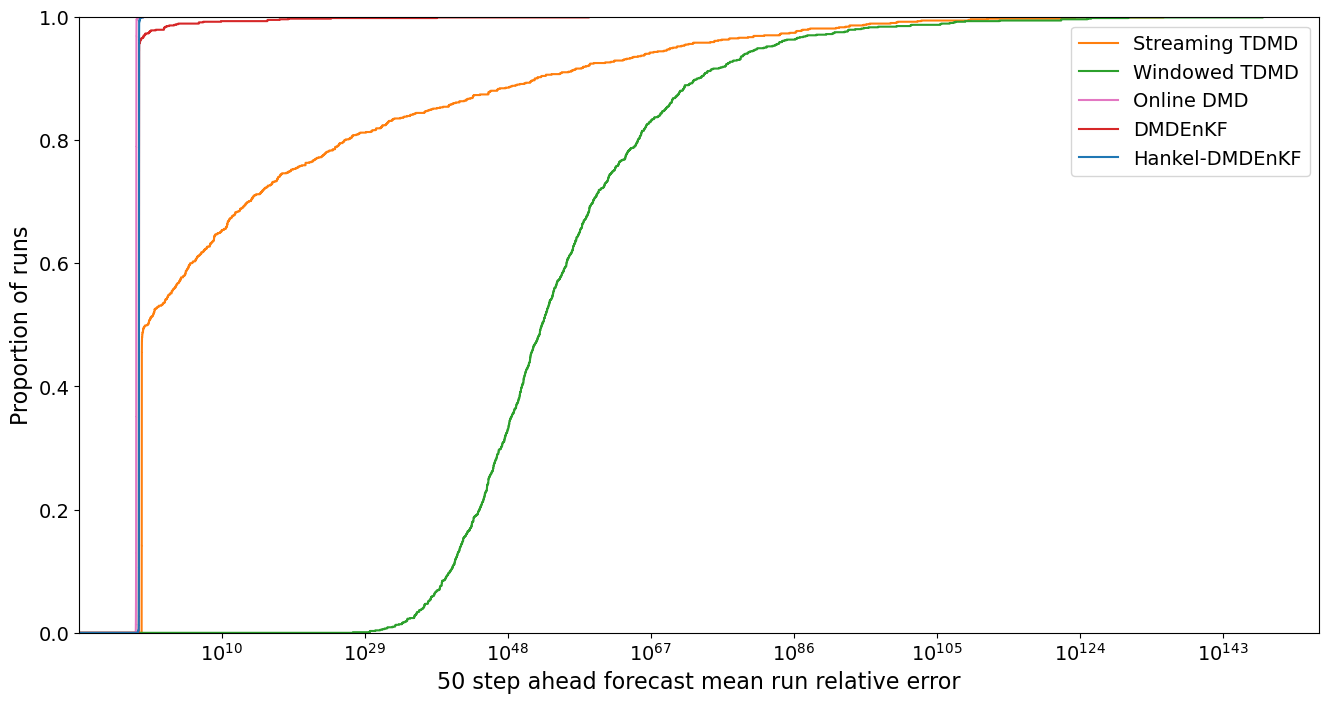

In [9]:
plt.rcParams["figure.figsize"] = (16,8) # (w, h)
#ecdf low noise plot to show why we dont bother with WTDMD and STDMD
plt.xscale('log')
sb.ecdfplot(run_means[0],label='Streaming TDMD',color='tab:orange')
sb.ecdfplot(run_means[1],label='Windowed TDMD',color='tab:green')
sb.ecdfplot(run_means[2],label='Online DMD',color='tab:pink')
sb.ecdfplot(run_means[3],label='DMDEnKF',color='tab:red')
sb.ecdfplot(run_means[4],label='Hankel-DMDEnKF',color='tab:blue')
plt.legend()
plt.ylabel('Proportion of runs')
plt.xlabel('50 step ahead forecast mean run relative error')
plt.savefig(f'graphs/{np.sqrt(obs_cov_const)}ecdf_errors_all.png',bbox_inches='tight')

### Plot the 50-step ahead forecast error distributions for the 3 best performing methods on the low noise data

/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

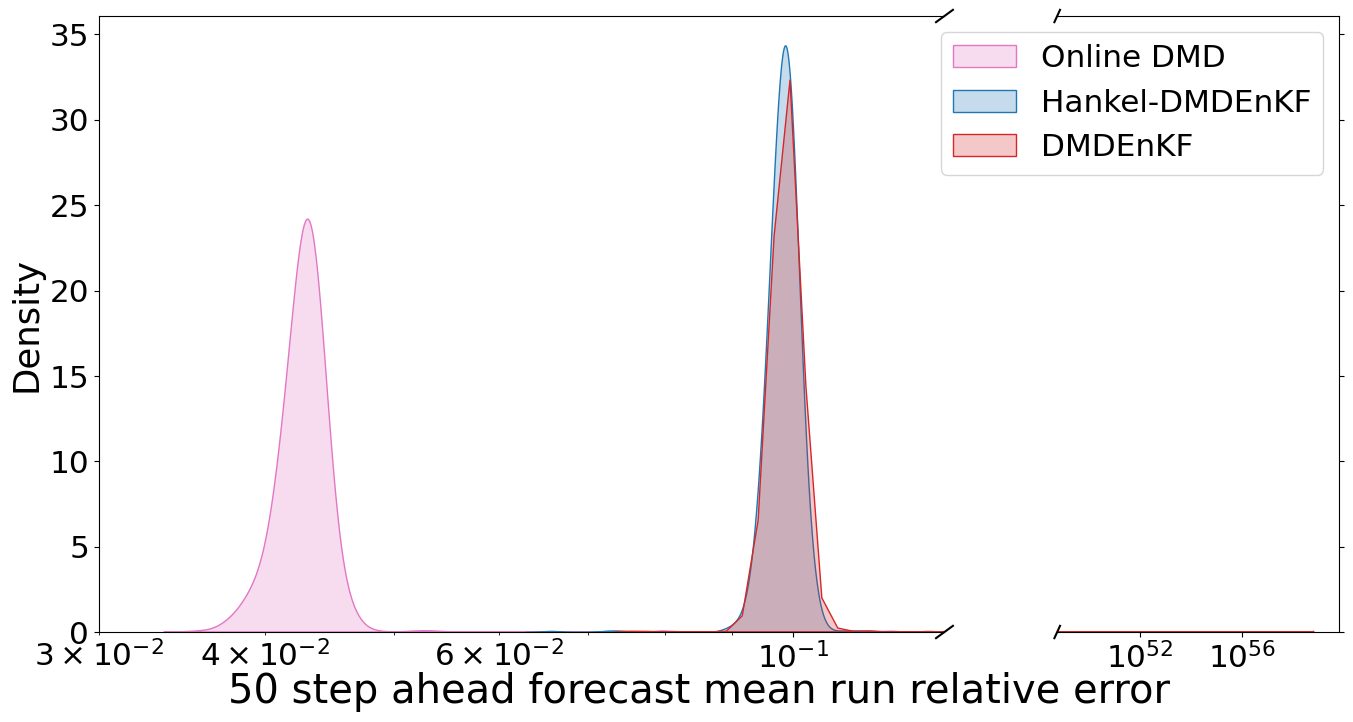

In [6]:
#growth decay error distributions 0.05
plt.rcParams["figure.figsize"] = (16,8) # (w, h)
scaling = 1.6
SMALL_SIZE = 14*scaling
MEDIUM_SIZE = 16*scaling
BIGGER_SIZE = 18*scaling
plt.rc('font', size=SMALL_SIZE)           # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#plot all error distributions
#define fig with 2 axes, this is a hack to plot a discontinuous y axis
f, (ax, ax2) = plt.subplots(1, 2, sharey=True,gridspec_kw={'width_ratios': [3, 1]})
ax.set_xscale('log')
ax2.set_xscale('log')
sb.distplot(run_means[2], hist=False,kde_kws = {'shade': True,'gridsize':5000},label='Online DMD',color='tab:pink',ax=ax)
sb.distplot(run_means[4],hist=False,kde_kws = {'shade': True,'gridsize':5000},label='Hankel-DMDEnKF',color='tab:blue',ax=ax)
sb.distplot(run_means[3], hist=False,kde_kws = {'shade': True,'gridsize':5000,'bw_method':0.1*FFTKDE(kernel='gaussian', bw='ISJ').fit(np.log(run_means[3])).bw},label='DMDEnKF',color='tab:red',ax=ax)

sb.distplot(run_means[2], hist=False,kde_kws = {'shade': True,'gridsize':5000},label='Online DMD',color='tab:pink',ax=ax2)
sb.distplot(run_means[4],hist=False,kde_kws = {'shade': True,'gridsize':5000},label='Hankel-DMDEnKF',color='tab:blue',ax=ax2)
sb.distplot(run_means[3], hist=False,kde_kws = {'shade': True,'gridsize':5000,'bw_method':0.1*FFTKDE(kernel='gaussian', bw='ISJ').fit(np.log(run_means[3])).bw},label='DMDEnKF',color='tab:red',ax=ax2)

#set axis limits for each discontinous section
ax.set_xlim(0.03,0.13)
ax2.set_xlim(float(np.max(run_means[3])*(10**-10)),float(np.max(run_means[3])*(10**1)))

# hide the spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax.yaxis.tick_left()
ax2.yaxis.tick_right()

d = .01 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d), (-d,+d), **kwargs)
ax.plot((1-d,1+d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)

#set axis labels
f.supxlabel('50 step ahead forecast mean run relative error')
plt.legend()
#plt.savefig(f'graphs/{np.sqrt(obs_cov_const)}growth_decay_error_distributions.png',bbox_inches='tight')

### Calculate the percentage of outliers (via the IQR method) for the low noise data

In [7]:
spf.iqr_outlier_detection(run_means[3])

Outlier Percentage: 5.5%


0.055

### Load the pre-run, high noise trajectories from their pickles

In [8]:
#load the high noise prediction errors
obs_cov_const = high_obs_cov_const
#load all trajectories
with open(f'data/{np.sqrt(obs_cov_const)}simulated_pandemic_distributions.pkl', 'rb') as f:
    all_trajs = pickle.load(f)

#convert into the mean error over each run
run_means = np.split(all_trajs,1000,axis=1)
run_means = np.array([np.mean(r,axis=1) for r in run_means]).T

### Plot the 50-step ahead forecast error distributions for the 3 best performing methods on the high noise data

/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

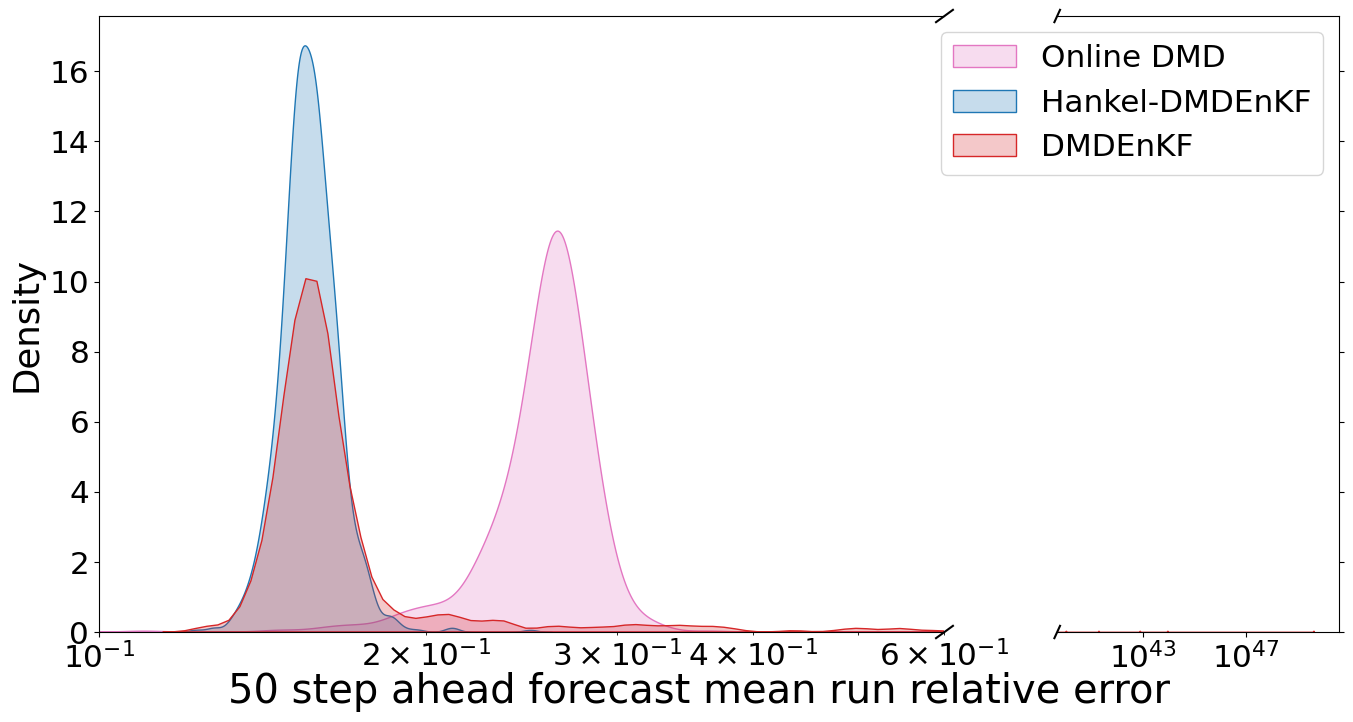

In [9]:
plt.rcParams["figure.figsize"] = (16,8) # (w, h)
#plot all error distributions
#define fig with 2 axes, this is a hack to plot a discontinuous y axis
f, (ax, ax2) = plt.subplots(1, 2, sharey=True,gridspec_kw={'width_ratios': [3, 1]})
ax.set_xscale('log')
ax2.set_xscale('log')
sb.distplot(run_means[2], hist=False,kde_kws = {'shade': True,'gridsize':5000},label='Online DMD',color='tab:pink',ax=ax)
sb.distplot(run_means[4],hist=False,kde_kws = {'shade': True,'gridsize':5000},label='Hankel-DMDEnKF',color='tab:blue',ax=ax)
sb.distplot(run_means[3], hist=False,kde_kws = {'shade': True,'gridsize':5000,'bw_method':0.1*FFTKDE(kernel='gaussian', bw='ISJ').fit(np.log(run_means[3])).bw},label='DMDEnKF',color='tab:red',ax=ax)

sb.distplot(run_means[2], hist=False,kde_kws = {'shade': True,'gridsize':5000},label='Online DMD',color='tab:pink',ax=ax2)
sb.distplot(run_means[4],hist=False,kde_kws = {'shade': True,'gridsize':5000},label='Hankel-DMDEnKF',color='tab:blue',ax=ax2)
sb.distplot(run_means[3], hist=False,kde_kws = {'shade': True,'gridsize':5000,'bw_method':0.1*FFTKDE(kernel='gaussian', bw='ISJ').fit(np.log(run_means[3])).bw},label='DMDEnKF',color='tab:red',ax=ax2)

#set axis limits for each discontinous section
ax.set_xlim(0.1,0.6)
ax2.set_xlim(float(np.max(run_means[3])*(10**-10)),float(np.max(run_means[3])*(10**1)))

# hide the spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax.yaxis.tick_left()
ax2.yaxis.tick_right()

d = .01 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d), (-d,+d), **kwargs)
ax.plot((1-d,1+d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)

#set axis labels
f.supxlabel('50 step ahead forecast mean run relative error')
plt.legend()
#plt.savefig(f'graphs/{np.sqrt(obs_cov_const)}growth_decay_error_distributions.png',bbox_inches='tight')

### Calculate the percentage of outliers (via the IQR method) for the high noise data

In [10]:
spf.iqr_outlier_detection(run_means[3])

Outlier Percentage: 21.9%


0.219

### Generate data with both high and low levels of measurement noise

In [11]:
#Generate data
obs_cov_const = low_obs_cov_const
system_cov_const = (obs_cov_const/10)**2
random_state = 0
np.random.seed(random_state)
As = spf.generate_growth_decay_operators(3,max_growth,max_decay,num_data-1)
true_data = spf.generate_data(As)
#add noise
data = true_data + np.random.multivariate_normal([0]*3,obs_cov_const*np.identity(3),num_data).T
high_noise_data = true_data + np.random.multivariate_normal([0]*3,high_obs_cov_const*np.identity(3),num_data).T

### Plot the true data with and without each level of measurement noise

Text(0, 0.5, 'State Values')

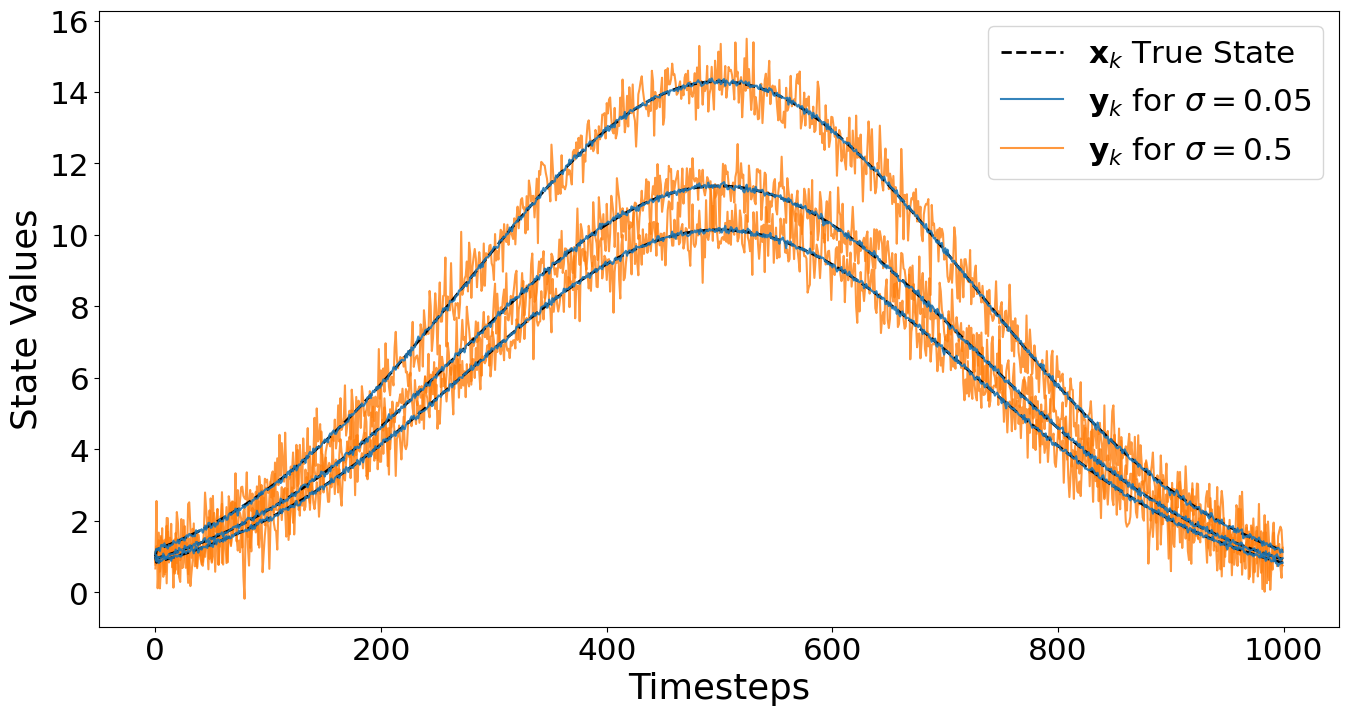

In [12]:
#growth decay data
#State values of a randomly generated system whose dominant eigenvalue is linearly decreased from 1.01 to 0.99 over the course of 1000 timesteps.

for i in range(3):
    
    plt.plot(true_data[i],label =r'$\mathbf{x}_k$ True State',alpha = 1,zorder=9, linewidth='2', ls='--',color='black')
    plt.plot(data[i],alpha=0.9, color='tab:blue',zorder=10,label=r'$\mathbf{y}_k$ for $\sigma = 0.05$')
    plt.plot(high_noise_data[i],alpha=0.8,color='tab:orange', label=r'$\mathbf{y}_k$ for $\sigma = 0.5$')
    if i == 0:
        plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('State Values')
#plt.savefig(f'graphs/growth_decay_data.png', bbox_inches='tight')

### Apply each iterative DMD variant to the low noise data

In [13]:
#Appply STDMD to the data
streaming_tdmd_preds, streaming_tdmd_eigs = spf.iterate_streaming_tdmd(data,n_step_ahead)
streaming_tdmd_preds = np.hstack(streaming_tdmd_preds)

#Appply WTDMD to the data
windowed_tdmd_preds, windowed_tdmd_eigs = spf.windowed_tdmd(data,window_size,n_step_ahead)
windowed_tdmd_preds = np.hstack(windowed_tdmd_preds)

#Appply ODMD to the data
odmd_preds, odmd_eigs = spf.iterate_odmd(data,rho,n_step_ahead)
odmd_preds = np.hstack(odmd_preds)
print('Doing DMDEnKF')
#Appply DMDEnKF to the data
dmdenkf_preds, dmdenkf_eigs, dmdenkf = spf.apply_dmdenkf(data,num_for_spin_up,
                                                     system_cov_const,obs_cov_const,eig_cov_const,
                                                    ensemble_size,n_step_ahead)
print('Doing Hankel DMDEnKF')
#Appply HDMDEnKF to the data
hdmdenkf_preds, hdmdenkf_eigs, hdmdenkf = spf.apply_hankel_dmdenkf(data,num_for_spin_up,hankel_dim,
                                                              system_cov_const,obs_cov_const,eig_cov_const,
                                                              ensemble_size,n_step_ahead)
#stack preds and eigs
all_method_predictions = [streaming_tdmd_preds,windowed_tdmd_preds,odmd_preds,dmdenkf_preds,hdmdenkf_preds]
eigenvalues = [streaming_tdmd_eigs,windowed_tdmd_eigs,odmd_eigs,dmdenkf_eigs,hdmdenkf_eigs]
#post process preds and eigs to ensure everything is properly aligned
min_index = min([pred.shape[1] for pred in all_method_predictions])
all_method_predictions = [pred[:3,-min_index:-n_step_ahead] for pred in all_method_predictions]
eigenvalues = [np.max(abs(np.array(e)),axis=1)[-(min_index-n_step_ahead):] for e in eigenvalues]
#align true data, noisy data and eigs
aligned_truth = true_data[:,-(min_index-n_step_ahead):]
aligned_data = data[:,-(min_index-n_step_ahead):]
aligned_eigs = np.linspace(max_growth,max_decay,num_data)[-(min_index-n_step_ahead):]

Doing DMDEnKF
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273


### Plot what typical 50-step ahead forecasts would look like for the best performing 3 methods on low noise data

/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


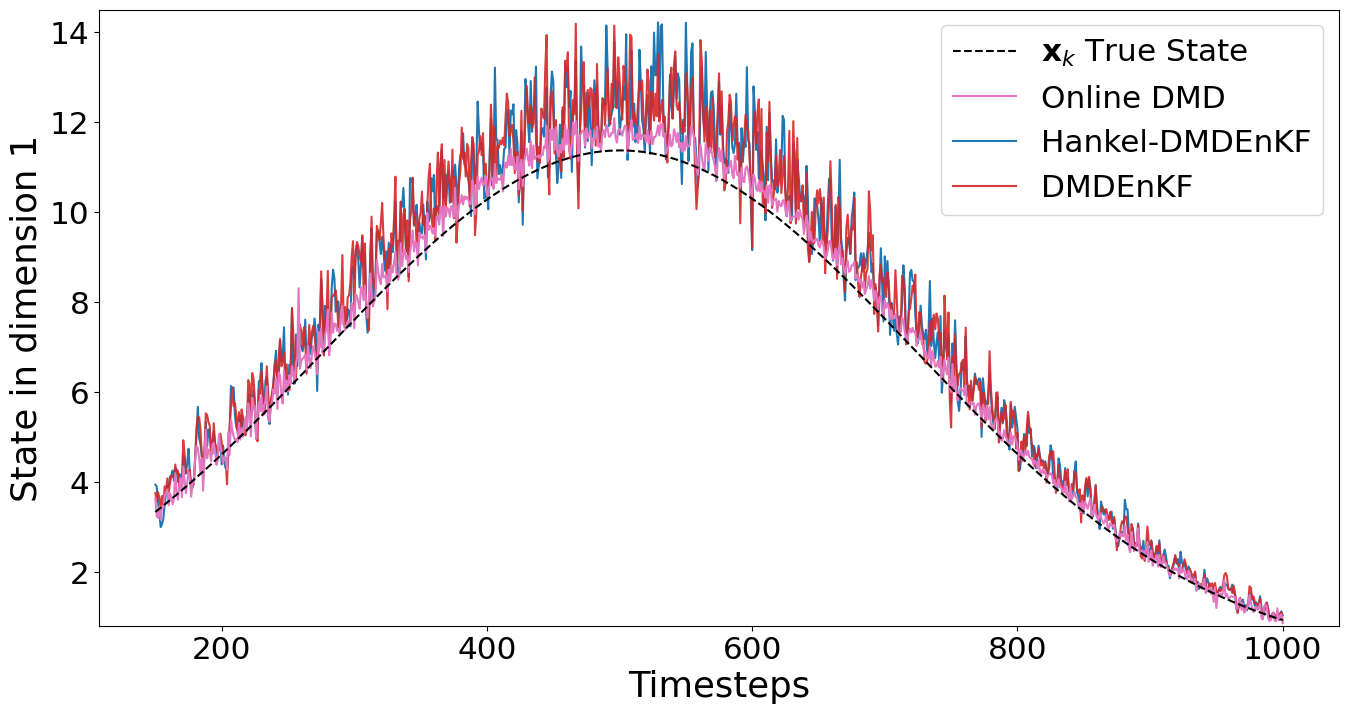

In [14]:
#growth decay typical forecast
#A typical trajectory of the 50 step ahead forecasts produced using Online DMD and the DMDEnKF with measurement noise $\sigma = 0.5$.

state_dim = 0
plt.plot(aligned_truth[state_dim],label=r'$\mathbf{x}_k$ True State',c='black',linestyle='--',zorder=10)
#plt.plot(all_method_predictions[0][state_dim],label='Streaming TDMD',c='tab:orange',zorder=3)
#plt.plot(all_method_predictions[1][state_dim],label='Windowed TDMD',zorder=-10,c='tab:green',alpha=0.25)
plt.plot(all_method_predictions[2][state_dim],label='Online DMD',c='tab:pink',zorder=5)
plt.plot(all_method_predictions[4][state_dim],label='Hankel-DMDEnKF',c='tab:blue',zorder=2)
plt.plot(all_method_predictions[3][state_dim],label='DMDEnKF',c='tab:red',alpha=0.9,zorder=4)
#change x ticks to end at 1000 and add y axis lims
plt.xlabel('Timesteps')
plt.ylabel('State in dimension 1')
plt.ylim(0.8,14.5)
last_data_index = all_method_predictions[0].shape[-1] - 1
ticks = [(last_data_index - 200*i) for i in range(10) if (last_data_index - 200*i)>=0]
labels = [(num_data - 200*i) for i in range(len(ticks))]
plt.xticks(ticks,labels)
plt.legend()
#plt.savefig(f'graphs/{np.sqrt(obs_cov_const)}growth_decay_typical_forecast.png',bbox_inches='tight')

### Plot what typical dominant eigenvalue modulus estimates would look like for the best performing 3 methods on low noise data

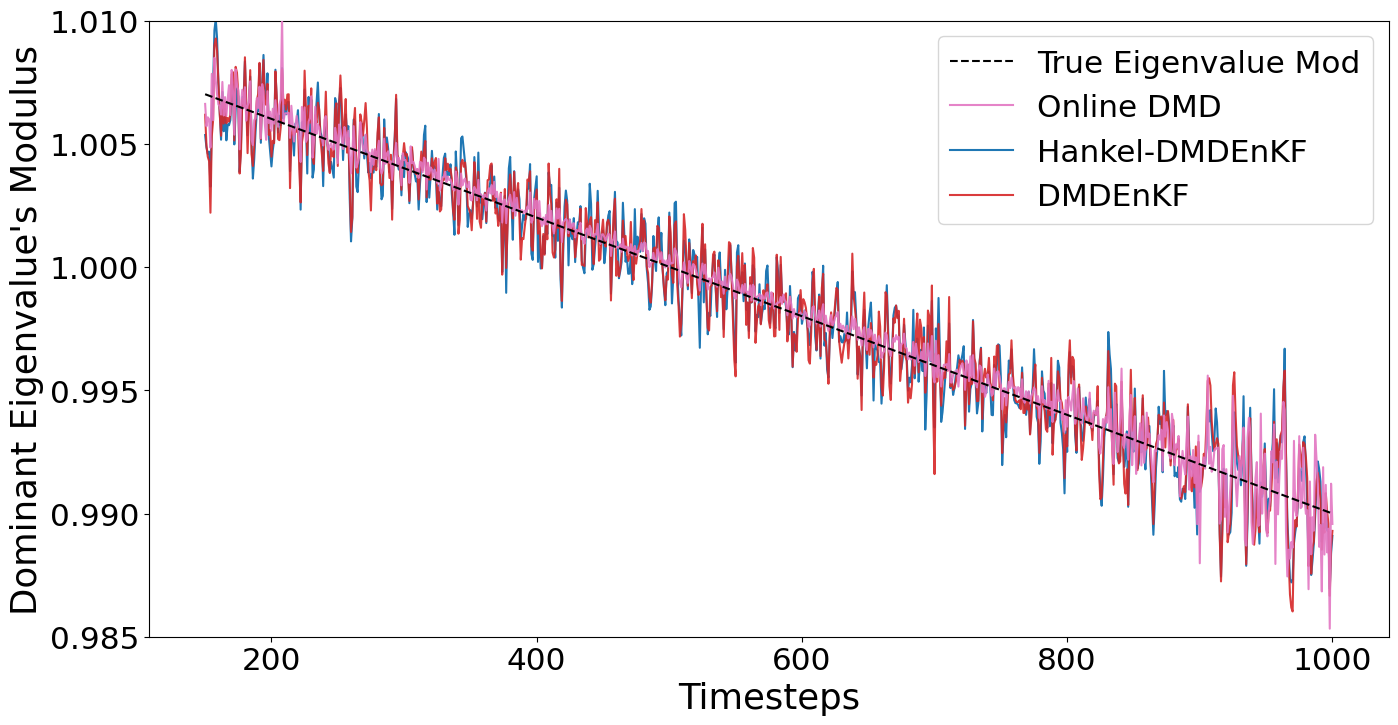

In [15]:
#growth decay typical eigs
#A typical trajectory of the eigs produced using Online DMD and the DMDEnKF with measurement noise $\sigma = 0.5$.

plt.plot(aligned_eigs,label=r'True Eigenvalue Mod',c='black',linestyle='--',zorder=10)
#plt.plot(eigenvalues[0],label='Streaming TDMD',c='tab:orange')
#plt.plot(eigenvalues[1],label='Windowed TDMD',zorder=-10,c='tab:green',alpha=0.25)
plt.plot(eigenvalues[2],label='Online DMD',c='tab:pink',zorder=5,alpha=0.9)
plt.plot(eigenvalues[4],label='Hankel-DMDEnKF',c='tab:blue')
plt.plot(eigenvalues[3],label='DMDEnKF',c='tab:red',alpha=0.9)
#change x ticks to end at 1000
plt.xlabel('Timesteps')
plt.ylabel("Dominant Eigenvalue's Modulus")
plt.xticks(ticks,labels)
plt.ylim(0.985,1.01)
plt.legend()
#plt.savefig(f'graphs/{np.sqrt(obs_cov_const)}growth_decay_typical_eigenvalue_tracking.png',bbox_inches='tight')

### Apply each iterative DMD variant to the high noise data

In [16]:
#Now perform run for high noise case
data = high_noise_data
obs_cov_const = high_obs_cov_const
system_cov_const = (obs_cov_const/10)**2
np.random.seed(0)
#Appply STDMD to the data
streaming_tdmd_preds, streaming_tdmd_eigs = spf.iterate_streaming_tdmd(data,n_step_ahead)
streaming_tdmd_preds = np.hstack(streaming_tdmd_preds)

#Appply WTDMD to the data
windowed_tdmd_preds, windowed_tdmd_eigs = spf.windowed_tdmd(data,window_size,n_step_ahead)
windowed_tdmd_preds = np.hstack(windowed_tdmd_preds)

#Appply ODMD to the data
odmd_preds, odmd_eigs = spf.iterate_odmd(data,rho,n_step_ahead)
odmd_preds = np.hstack(odmd_preds)
print('Doing DMDEnKF')
#Appply DMDEnKF to the data
dmdenkf_preds, dmdenkf_eigs, dmdenkf = spf.apply_dmdenkf(data,num_for_spin_up,
                                                     system_cov_const,obs_cov_const,eig_cov_const,
                                                    ensemble_size,n_step_ahead)
print('Doing Hankel DMDEnKF')
#Appply HDMDEnKF to the data
hdmdenkf_preds, hdmdenkf_eigs, hdmdenkf = spf.apply_hankel_dmdenkf(data,num_for_spin_up,hankel_dim,
                                                              system_cov_const,obs_cov_const,eig_cov_const,
                                                              ensemble_size,n_step_ahead)
#stack preds and eigs
all_method_predictions = [streaming_tdmd_preds,windowed_tdmd_preds,odmd_preds,dmdenkf_preds,hdmdenkf_preds]
eigenvalues = [streaming_tdmd_eigs,windowed_tdmd_eigs,odmd_eigs,dmdenkf_eigs,hdmdenkf_eigs]
#post process preds and eigs to ensure everything is properly aligned
min_index = min([pred.shape[1] for pred in all_method_predictions])
all_method_predictions = [pred[:3,-min_index:-n_step_ahead] for pred in all_method_predictions]
eigenvalues = [np.max(abs(np.array(e)),axis=1)[-(min_index-n_step_ahead):] for e in eigenvalues]
#align true data, noisy data and eigs
aligned_truth = true_data[:,-(min_index-n_step_ahead):]
aligned_data = data[:,-(min_index-n_step_ahead):]
aligned_eigs = np.linspace(max_growth,max_decay,num_data)[-(min_index-n_step_ahead):]

Doing DMDEnKF
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273


### Plot what typical 50-step ahead forecasts would look like for the best performing 3 methods on high noise data

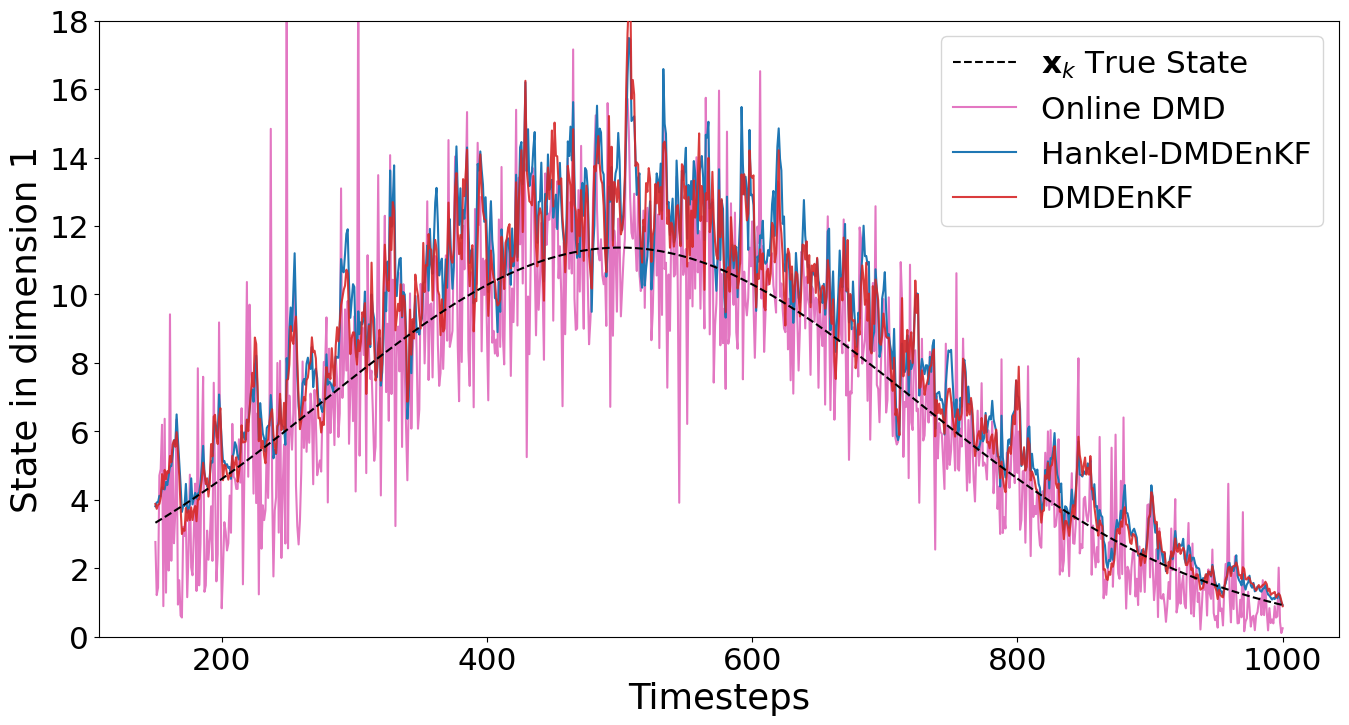

In [17]:
#growth decay typical forecast
#A typical trajectory of the 50 step ahead forecasts produced using Online DMD and the DMDEnKF with measurement noise $\sigma = 0.5$.

state_dim = 0
plt.plot(aligned_truth[state_dim],label=r'$\mathbf{x}_k$ True State',c='black',linestyle='--',zorder=10)
#plt.plot(all_method_predictions[0][state_dim],label='Streaming TDMD',c='tab:orange',zorder=0,alpha=0.5)
#plt.plot(all_method_predictions[1][state_dim],label='Windowed TDMD',zorder=-10,c='tab:green',alpha=0.25)
plt.plot(all_method_predictions[2][state_dim],label='Online DMD',c='tab:pink',zorder=1)
plt.plot(all_method_predictions[4][state_dim],label='Hankel-DMDEnKF',c='tab:blue',zorder=2)
plt.plot(all_method_predictions[3][state_dim],label='DMDEnKF',c='tab:red',alpha=0.9,zorder=4)
#change x ticks to end at 1000 and add y axis lims
plt.xlabel('Timesteps')
plt.ylabel('State in dimension 1')
plt.ylim(0,18)
plt.xticks(ticks,labels)
plt.legend()
#plt.savefig(f'graphs/{np.sqrt(obs_cov_const)}growth_decay_typical_forecast.png',bbox_inches='tight')

### Plot what typical dominant eigenvalue modulus estimates would look like for the best performing 3 methods on high noise data

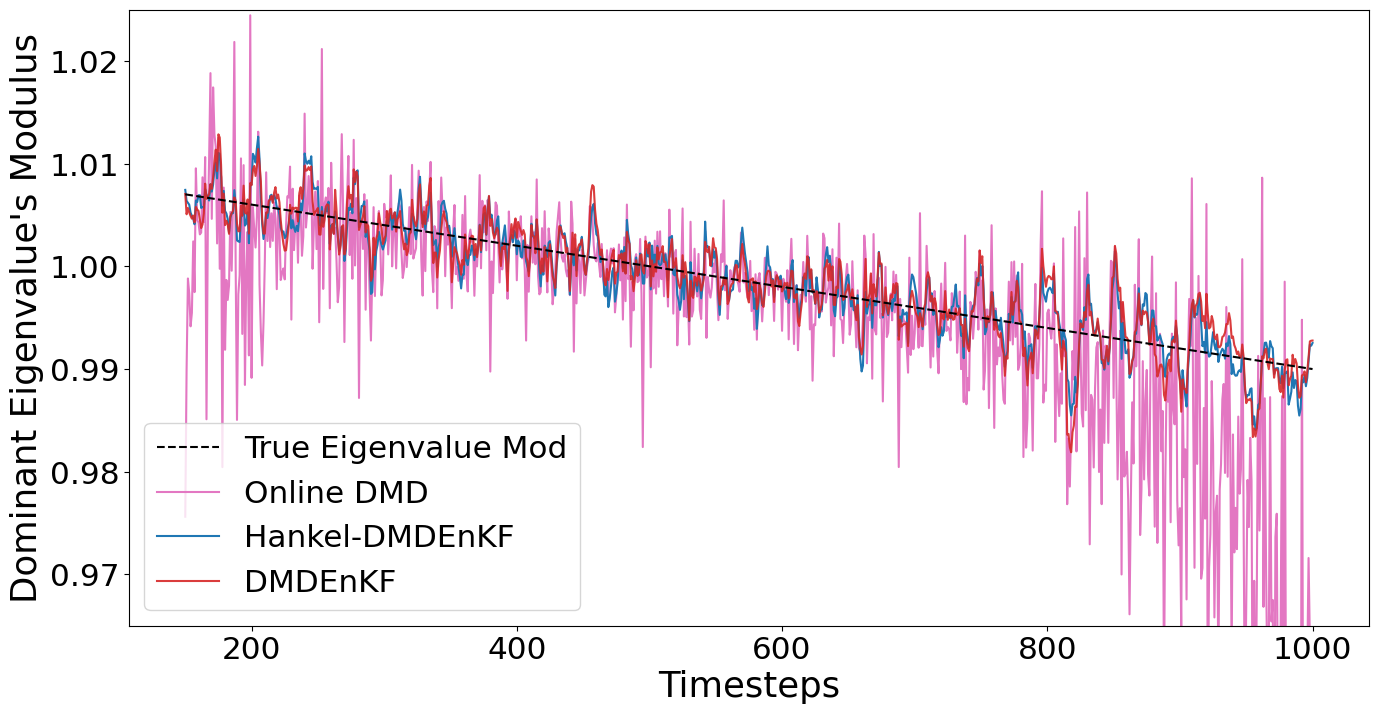

In [18]:
#growth decay typical eigs
#A typical trajectory of the eigs produced using Online DMD and the DMDEnKF with measurement noise $\sigma = 0.5$.

plt.plot(aligned_eigs,label=r'True Eigenvalue Mod',c='black',linestyle='--',zorder=10)
#plt.plot(eigenvalues[0],label='Streaming TDMD',c='tab:orange',zorder=0,alpha=0.5)
#plt.plot(eigenvalues[1],label='Windowed TDMD',zorder=-10,c='tab:green',alpha=0.25)
plt.plot(eigenvalues[2],label='Online DMD',c='tab:pink',zorder=1)
plt.plot(eigenvalues[4],label='Hankel-DMDEnKF',c='tab:blue')
plt.plot(eigenvalues[3],label='DMDEnKF',c='tab:red',alpha=0.9)
#change x ticks to end at 1000
plt.xlabel('Timesteps')
plt.ylabel("Dominant Eigenvalue's Modulus")
plt.xticks(ticks,labels)
plt.ylim(0.965,1.025)
plt.legend()
#plt.savefig(f'graphs/{np.sqrt(obs_cov_const)}growth_decay_typical_eigenvalue_tracking.png',bbox_inches='tight')